In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# base Value가 100 -> 1로 맞춰줌 / 시작일은 2017년 2월 28일
snp = pd.read_excel("s&p_coinmkt_index.xls", index_col=0,
                    parse_dates=True) / 100

In [2]:
mktcap = pd.read_pickle("ryu_new_mktcap2.pickle")
price  = pd.read_pickle("ryu_new_price.pickle")

rtn = price.pct_change(fill_method=None) * np.sign(price)

## 마켓 리턴

1. BTC의 Weight

2. 마켓 인덱스

3. S&P Global의 Coinmkt index

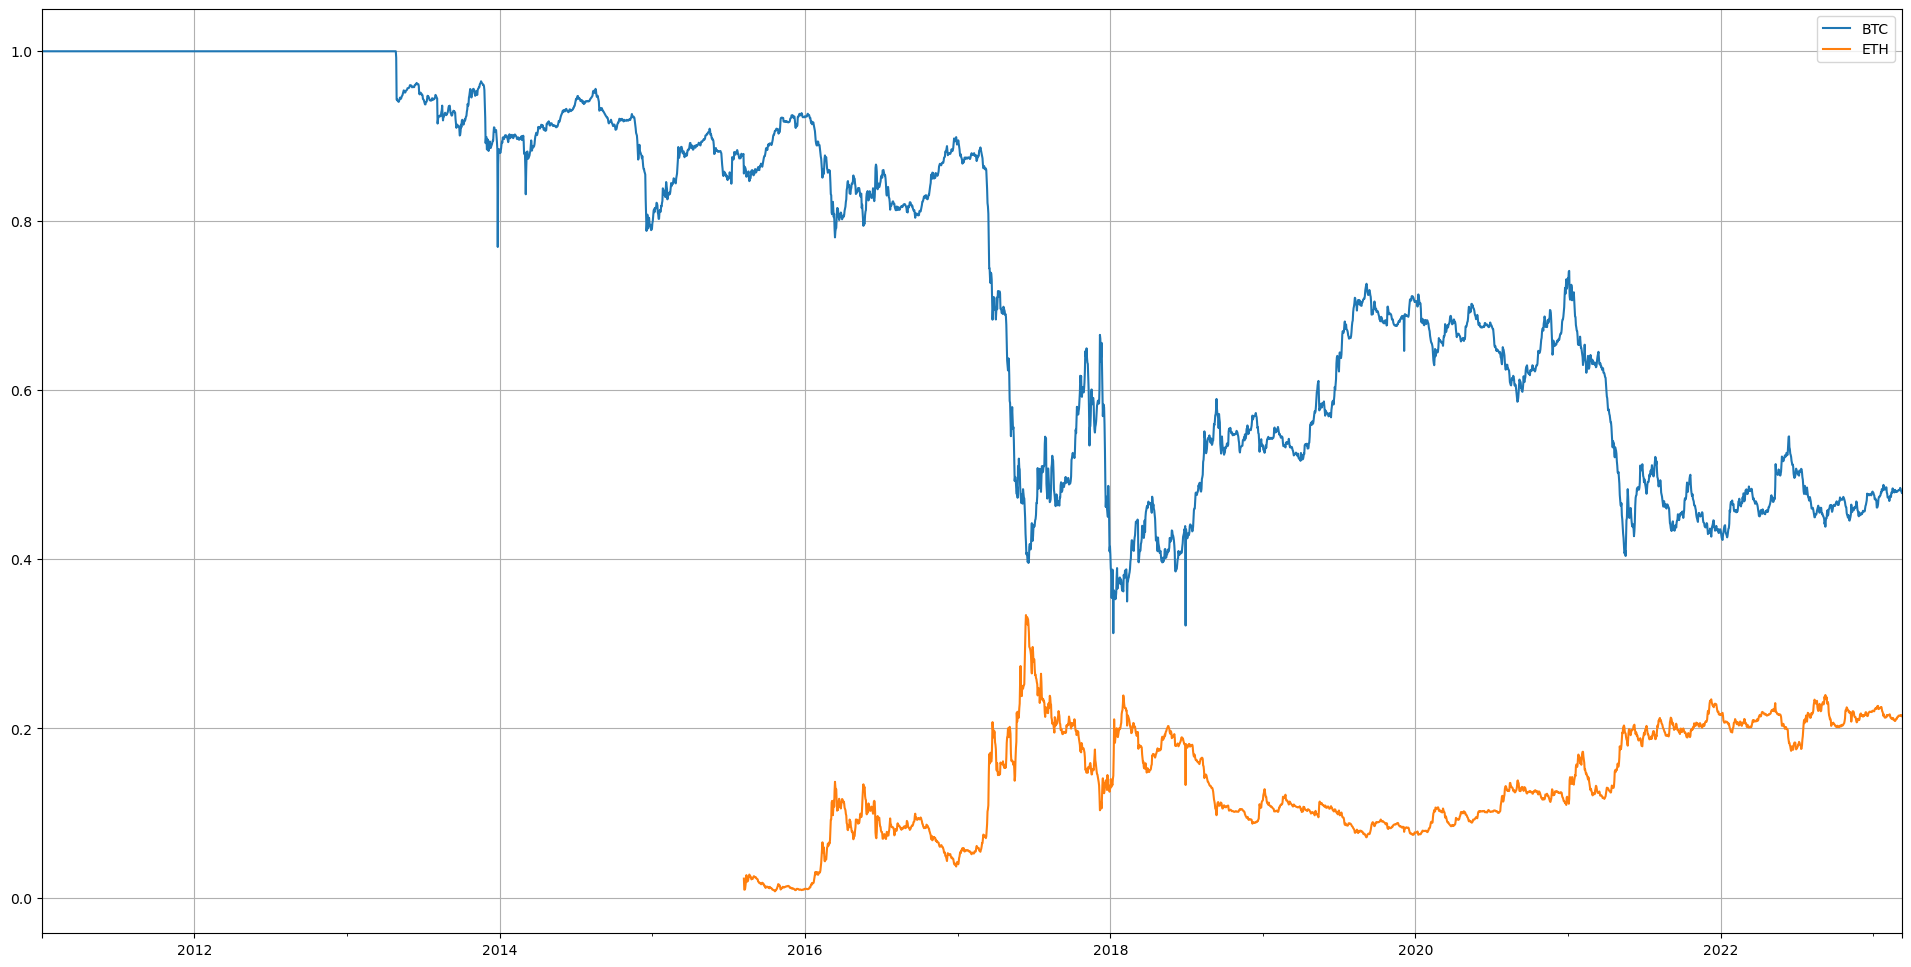

In [3]:
# 마켓 웨이트
weight = mktcap.apply(lambda x: x/np.nansum(x), axis=1)
weight[["BTC","ETH"]].plot(figsize=(24,12))
plt.grid();

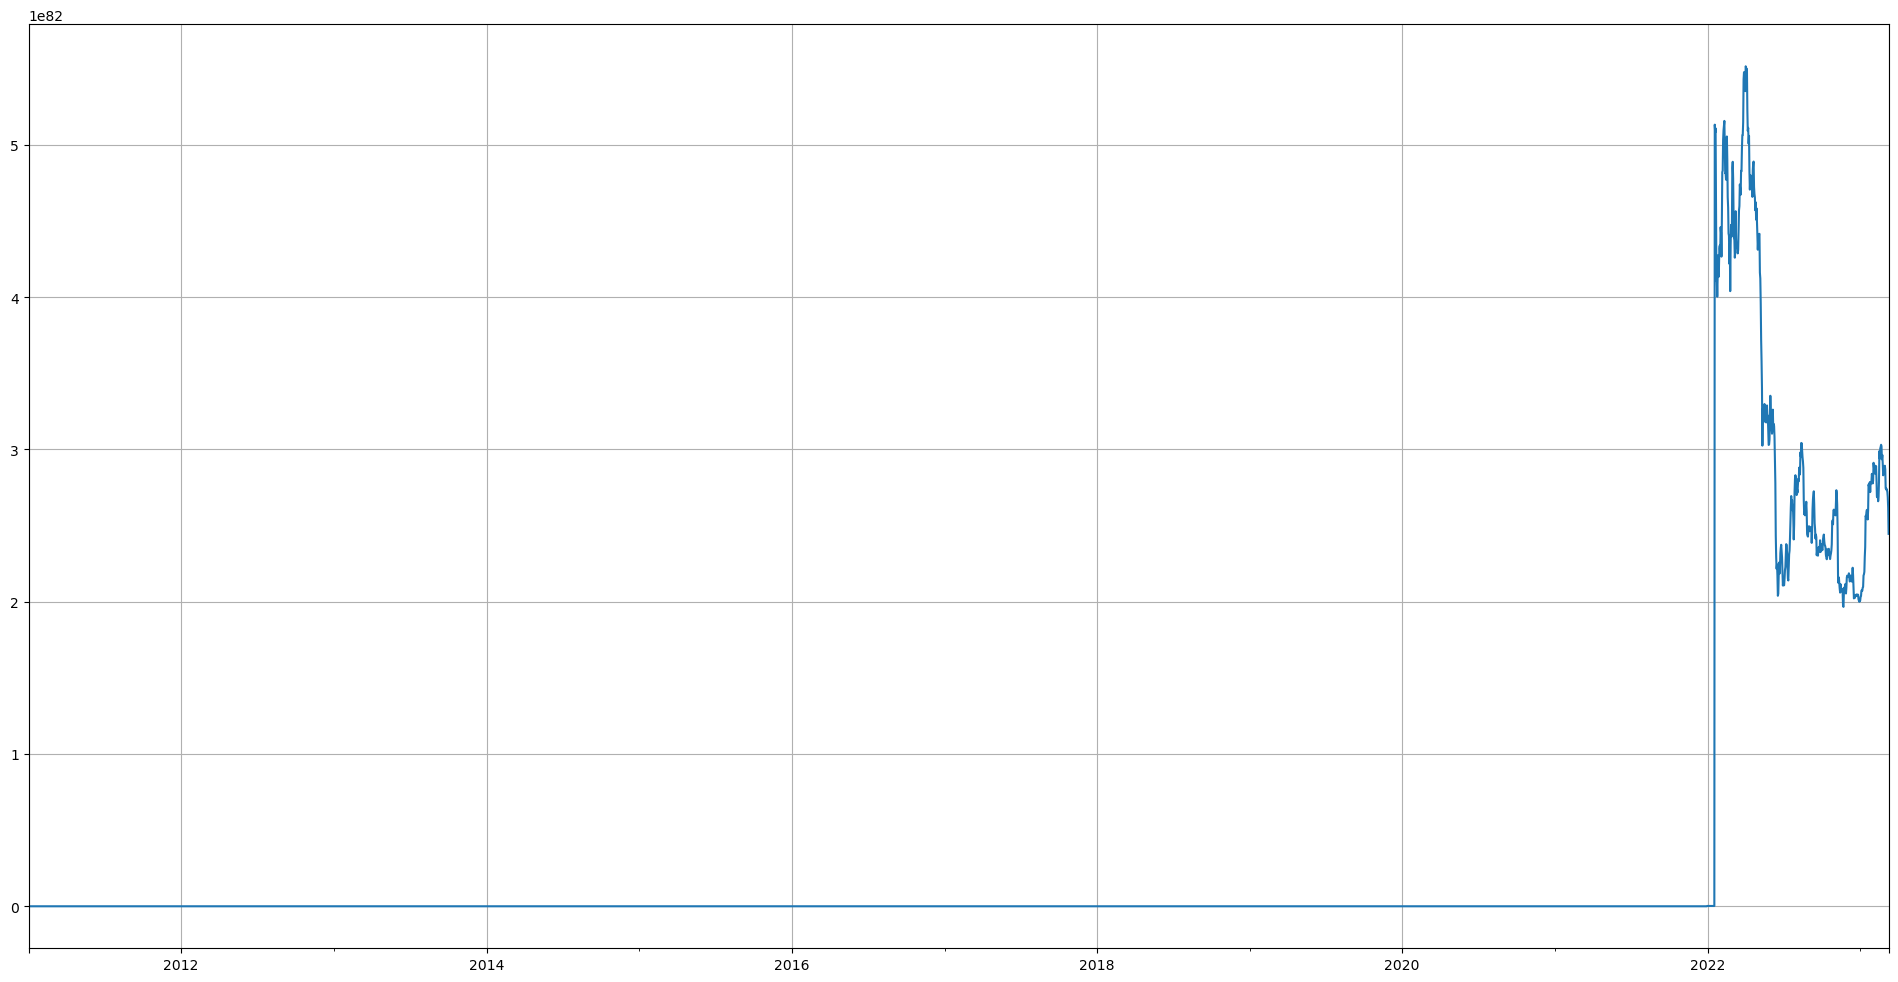

In [4]:
mkt_rtn = ((weight*rtn).sum(1)+ 1).cumprod()
mkt_rtn.plot(figsize=(24,12))
plt.grid();

NameError: name 'snp' is not defined

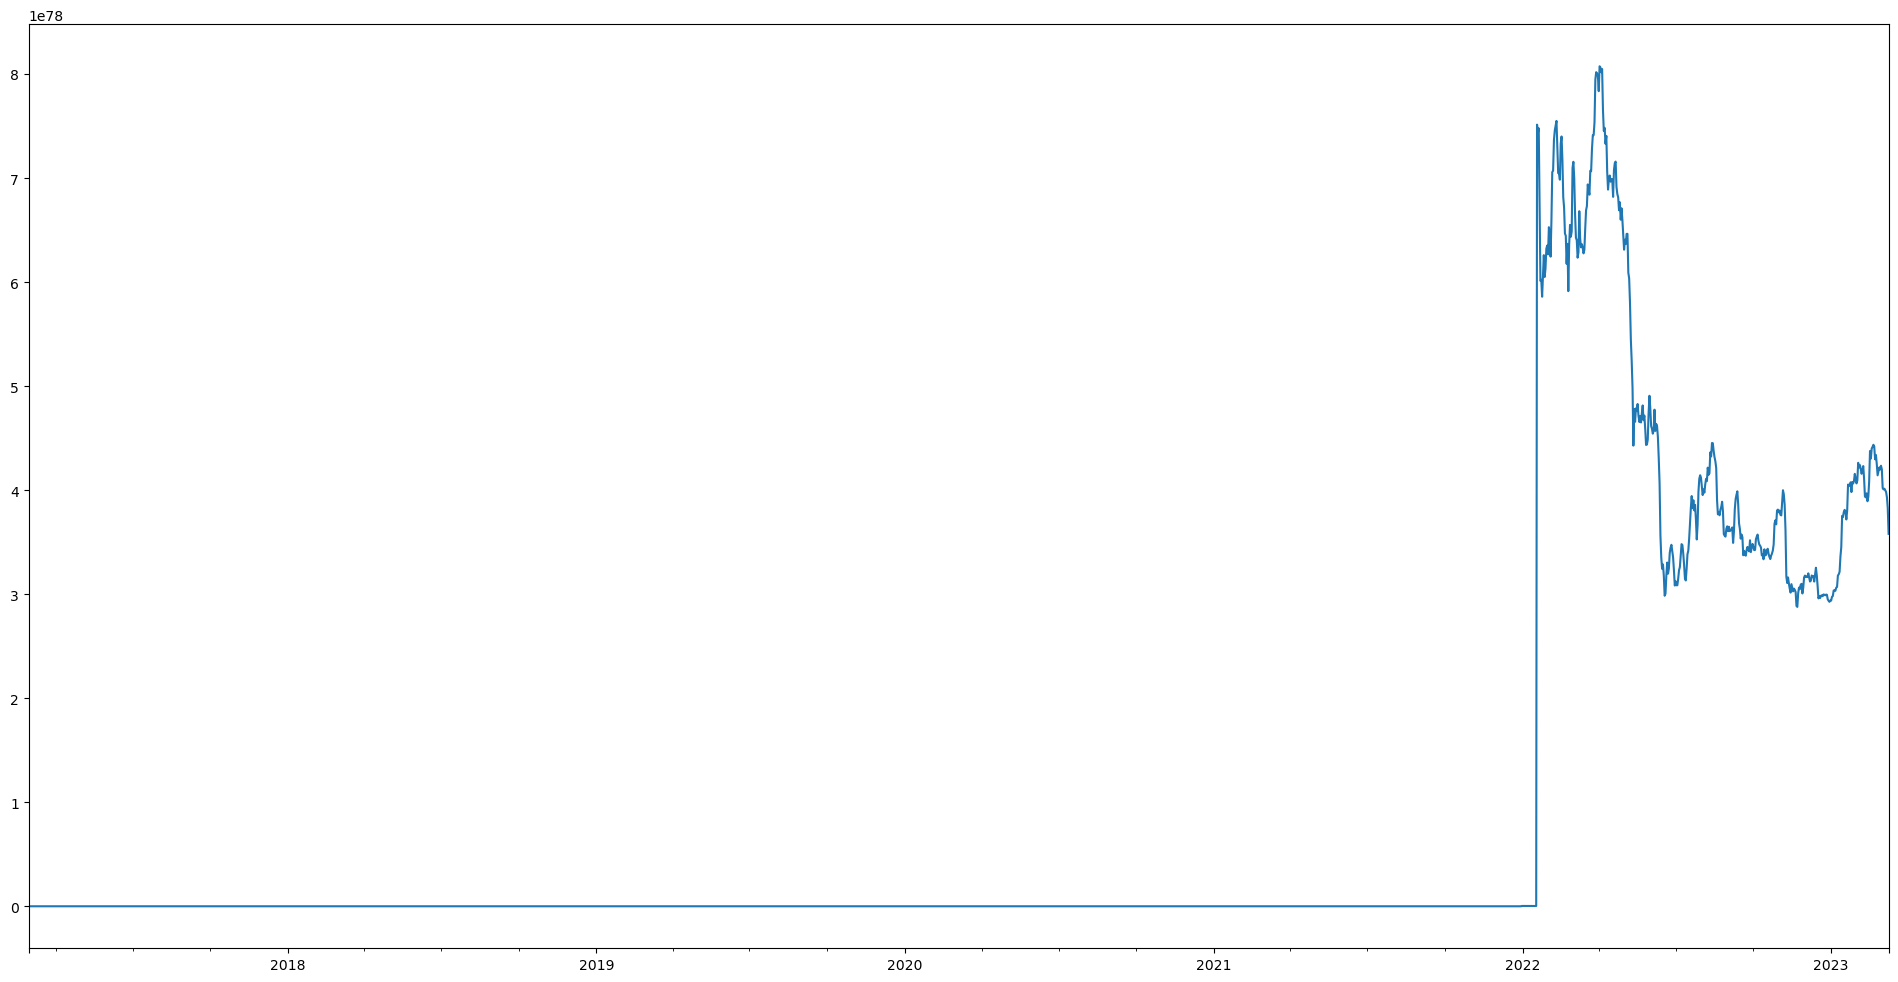

In [6]:
# 에센피 인덱스랑, 우리 데이터 인덱스랑 둘을 같이 그리기
fig, ax = plt.subplots(1,1)
(mkt_rtn.loc["2017-02-28":] / mkt_rtn.loc["2017-02-28"]).plot(figsize=(24,12), ax=ax)
snp.plot(ax=ax)
plt.grid();

In [ ]:
# Momentum 그룹을 나눌 thresh를 계산함
quintile = [0.2, 0.4, 0.6, 0.8]
thresh = rtn.apply(lambda x: np.nanquantile(x,quintile), # 
                   axis=1)

In [ ]:
quintile = [0.2, 0.4, 0.6, 0.8]
thresh = rtn.apply(lambda x: np.nanquantile(x,quintile), # 
                   axis=1)
t1 = thresh.apply(lambda x: x[0])
t2 = thresh.apply(lambda x: x[1])
t3 = thresh.apply(lambda x: x[2])
t4 = thresh.apply(lambda x: x[3])

# Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
q1 = rtn.apply(lambda x: x <= t1, axis=0) \
                  .replace(True, 1).replace(False, np.nan)
q2= rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
q3 = rtn.apply(lambda x: (t2 < x) & (x <= t3), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
q4 =  rtn.apply(lambda x: (t3 < x) & (x <= t4), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
q5 =  rtn.apply(lambda x: x > t4, axis=0) \
                  .replace(True, 1).replace(False, np.nan)
                  
# 횡단면 코인 개수가 그룹별로  num_of_coin_in_group이 넘는 날짜를 출력하자                  
num_coin = pd.concat([q1.sum(1), q2.sum(1), q3.sum(1), 
                      q4.sum(1), q5.sum(1)], axis=1)

slice = num_coin[num_coin >= num_of_coin_in_group].dropna(axis=0)
start_date = slice.index[0]
print("{}에서부터 수익률을 계산".format(start_date))          
        
# 그룹별로 시가총액 weight를 계산
rtn_dict = {}
i = 1

for group_mask in tqdm([q1, q2, q3, q4, q5]):
    masked_mktcap = (group_mask * mktcap).loc[start_date:].iloc[:-1] 
    masked_mktcap_ffill = pd.DataFrame(index=daily_price.index,
                                columns=daily_price.columns) \
                                .fillna(masked_mktcap) \
                                .ffill(limit=6)
    daily_mask = np.sign(daily_price)
    group_weight_daily = (daily_mask * masked_mktcap_ffill) \
                        .apply(lambda x: x / np.nansum(x), axis=1)
    group_rtn = (group_weight_daily.shift(7) * daily_rtn.loc[start_date:].iloc[:-1]).sum(1)
    rtn_dict["Q"+str(i)] = group_rtn
    i +=1


In [ ]:
# pct를 구해줌
pct = price.pct_change(fill_method=None)
pct_weekly = price.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총 weights 계산
mktcap_weekly = mktcap.resample("W").first()

weight_daily = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
weight_weekly = mktcap_weekly.apply(lambda x: x/ np.nansum(x), axis=1)

# nan처리를 위한 masking 생성
sign_daily = np.sign(price)
sign_weekly = np.sign(price.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
rtn_daily = sign_daily * pct
rtn_weekly = sign_weekly * pct_weekly

Daily 리밸런싱 구현해보자

# 마켓 리턴

In [ ]:
# 리턴 계산
## 주간 마켓 리턴
mktrtn_weekly = ((rtn_weekly * weight_weekly.shift(1)).sum(axis=1))

## daily 마켓 리턴
mktrtn_daily = ((rtn_daily * weight_daily.shift(1)).sum(axis=1))

In [ ]:
(mktrtn_daily + 1).cumprod().plot(figsize=(24,12))
plt.grid();

In [ ]:
#draw_return_result(mktrtn_weekly, "Weekly")

# 5분위수(모멘텀 기준)

In [ ]:
five_group_weekly = cross_sectional_momentum_quintile_weekly(rtn_weekly, 
                                                      price,
                                                      mktcap_weekly,
                                                      20, True)

In [ ]:
five_group_weekly.keys()

In [ ]:
(five_group_weekly["Q1"]).cumprod().plot(figsize=(24,12))
#plt.grid()

In [ ]:
draw_return_result(five_group_weekly["Q2"], freq="Weekly")

In [ ]:
# loc[:"2018"]을 없애면 포폴이 음수를 찍는 날이 나온다
q5q1 = (five_group_weekly["Q5"] - five_group_weekly["Q1"])
#draw_return_result(q5q1, "Daily")

통계량 찍어보자 / cov_type='HAC',cov_kwds={'maxlags':1}

In [ ]:
five_group_weekly["Q1"]

In [ ]:
run_alpha_regression(five_group_weekly["Q3"],mktrtn_weekly)

# 3분위수로 계산

In [ ]:
terciles_result = cross_sectional_momentum_terciles(rtn_daily, mktcap,
                                                    19, True)

In [ ]:
terciles_result["count"]

In [ ]:
draw_return_result(terciles_result["Q3"], "Daily")

In [ ]:
terciles_result['count']

In [ ]:
model = OLS(rtn5, 
            add_constant(result1.loc[start_date:] \
                                .iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date:].iloc[:-1],
            rtn2)
plt.xlabel("MKT Return")
plt.ylabel("Return of Q5");

In [ ]:
model = OLS(rtn_s, 
            add_constant(result1.loc[start_date2:].iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date2:].iloc[:-1],
            rtn_h)
plt.xlabel("MKT Return")
plt.ylabel("Return of H");
#plt.ylim(-0.7,1.5);

In [ ]:
mkt_sample = result1.loc[start_date:].iloc[:-1]

In [ ]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("G1:", rtn1.mean().round(4), rtn1.std(ddof=1))
print("G2:", rtn2.mean().round(4), rtn2.std(ddof=1))
print("G3:", rtn3.mean().round(4), rtn3.std(ddof=1))
print("G4:", rtn4.mean().round(4), rtn4.std(ddof=1))
print("G5:", rtn5.mean().round(4), rtn5.std(ddof=1))

t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)
t, p_val

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn1)
calculate_cagr(rtn2)
calculate_cagr(rtn3)
calculate_cagr(rtn4)
calculate_cagr(rtn5)

In [ ]:
concat_df = pd.concat([rtn1, rtn2, rtn3, rtn4 , rtn5, mkt_sample], 
                      axis=1)
concat_df.columns = ["One","Two","Three","Four","Five","MKT"]

concat_df.corr()

In [ ]:
# 3개 그룹의 결과를 뽑자
mkt_sample2 = result1.loc[start_date2:].iloc[:-1]
rtn_s_sample = rtn_s.loc[start_date2:]
rtn_m_sample = rtn_m.loc[start_date2:]
rtn_h_sample = rtn_h.loc[start_date2:]

In [ ]:
print("S:", rtn_s_sample.mean().round(4), rtn_s_sample.std(ddof=1))
print("M:", rtn_m_sample.mean().round(4), rtn_m_sample.std(ddof=1))
print("H:", rtn_h_sample.mean().round(4), rtn_h_sample.std(ddof=1))

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample2)

print("----------------")
print("Group Return")
calculate_cagr(rtn_s_sample)
calculate_cagr(rtn_m_sample)
calculate_cagr(rtn_h_sample)

In [ ]:
concat_df2 = pd.concat([rtn_s_sample, rtn_m_sample,
                        rtn_h_sample, mkt_sample2], 
                       axis=1)
concat_df2.columns = ["Low","Middle","High","MKT"]

concat_df2.corr()

In [ ]:
t, p_val = stats.ttest_ind(rtn_m_sample, 
                           rtn_h_sample)
t,p_val

In [ ]:
model = OLS(rtn_h_sample, 
            add_constant(mkt_sample2))
                            
model.fit().summary2()

In [ ]:
(result1.loc[start_date2:].iloc[:-1] +1)\
    .cumprod().plot(figsize=(24,12), label="Strategy")
(mkt_sample +1).cumprod().plot(figsize=(24,12),
                               label="MKT")
plt.legend();

* Long-Short 전략

코인 롱숏은 숏 한방을 얻어 맞고 죽는듯.....